# Benchmarking & Evaluation
The purpose of this notebook is to benchmark our implemented models against each other, as well as against other open source inpainting implementations

In [7]:
import os
import gc
from copy import deepcopy

# DISABLE GPU
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Change to root path
if os.path.basename(os.getcwd()) != 'PConv-Keras':
    os.chdir('..')

import matplotlib.pyplot as plt

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

from libs.data_loaders import AugmentingDataGenerator
from libs.unet_model import InpaintingUnet
from libs.util import MaskGenerator
from libs.eval import evaluate_model


%load_ext autoreload
%autoreload 2
plt.ioff()

# SETTINGS
TEST_DIR = r"/media/gruber/AuxDisk/ILSVRC/Data/CLS-LOC/test"
#TEST_DIR = '/Users/mathiasgruber/Documents/datasets/imagenette2/val'
MASK_DIR = r"./data/masks/test"
BATCH_SIZE = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Utility Functions
Utility functions for evaluating models

In [2]:
# Instantiate mask generator with preset masks
mask_generator = MaskGenerator(
    512, 512, 3, rand_seed=42, filepath=MASK_DIR, 
    rotation=False, dilation=False, cropping=False
)
mask_generator = MaskGenerator(512, 512, 3, rand_seed=42)

# Create testing generator
test_datagen = AugmentingDataGenerator(mask_generator, rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, 
    target_size=(512, 512), 
    batch_size=BATCH_SIZE, 
    seed=42
)

# Create inception model feature extractor, which returns 2048-dimensional features
inception_model = InceptionV3(include_top=True, weights="imagenet")
inception_model = Model(
    inputs=inception_model.input, 
    outputs=inception_model.layers[-2].output
)

>> Found 12000 masks in ./data/masks/test
Found 99943 images belonging to 1 classes.


# Evalulate PConv Network
Liu *et al.*,  **Image Inpainting for Irregular Holes Using Partial Convolutions**, https://arxiv.org/abs/1804.07723

In [ ]:
model = InpaintingUnet(
    conv_layer='pconv', 
    load_weights='./data/logs/imagenet_phase1/weights.01-35.29'
)

In [ ]:
df = evaluate_model(model, inception_model, test_generator, )

means.plot(yerr=stds, kind='bar')
plt.show()

# Evaluate GConv Network
Architecture from: * Liu *et al.*,  **Image Inpainting for Irregular Holes Using Partial Convolutions**, https://arxiv.org/abs/1804.07723

Conv Layer from : Yu *et al.*,  **Free-Form Image Inpainting with Gated Convolution**, https://arxiv.org/abs/1806.03589

In [4]:
model = InpaintingUnet(
    conv_layer='gconv', 
    load_weights='./data/logs/imagenet_phase1_gconv/weights.47-24.02'
)

Running model on 2 GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/devi

100%|██████████| 1000/1000 [02:07<00:00,  7.85it/s]


(512, 512, 3)
125/125 [==============================] - 4s 30ms/step


100%|██████████| 6/6 [00:01<00:00,  5.05it/s]


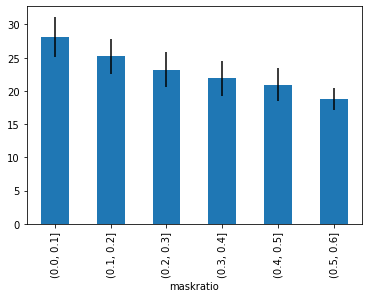

In [17]:
means, stds = evaluate_model(model, inception_model, test_generator, test_images=1000)
means.dropna(axis=0)['psnr'].plot(yerr=stds, kind='bar')
plt.show()

# Co-mod-GAN
Source: Zhao *et al.*, Large Scale Image Completion Via Co-Modulated Generative Adversarial Networks, https://openreview.net/pdf?id=sSjqmfsk95O

In [ ]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), 'co-mod-gan'))

In [ ]:
test_masks = os.listdir(MASK_DIR)
for i, filename in tqdm(enumerate(test_masks), total=len(test_masks)):

    # Load mask from paper
    filepath = os.path.join('./data/masks/test', filename)
    mask = cv2.imread(filepath) / 255        
    maskratio = mask[:,:,0].sum() / (512 * 512)
    mask = np.array([1-mask for _ in range(BATCH_SIZE)])        

    for _ in range(tests_per_image):

        # Pick out image from test generator
        test_data = next(test_generator)
        (masked, mask), true = test_data